## グラフ彩色問題 (Graph Coloring Problem)


グラフ彩色問題では、グラフ$G=(V,E)$と色の集合 $K$が与えられた時に、隣り合う色が同じにならないようにグラフのノードに色を割り当てる方法を探索するという問題です。今回はこの問題のQUBOをPyQUBOを使って作成します。
グラフ彩色問題のハミルトニアン$H$は以下の式によって表されます。


\begin{eqnarray*}
H &=& \alpha H_{A} + H_{B} \\
H_{A} &=& \sum_{i \in V} \left( 1 - \sum_{k = 1}^{K} x_{i,k}\right )^2 \\
H_{B} &=& \sum_{(i, j) \in E} \sum_{k = 1}^{K} x_{i,k} x_{j,k} .
\end{eqnarray*}

2値変数$x_{i,k}$はノード$i$の色が$k$の時に$1$となり、それ以外の時は$0$になる変数です。$H_{A}$はノードがどれかの色に割り当てられるための制約を表すハミルトニアンです。
$H_{B}$は隣り合うノードの色が同じにならないようにするためのペナルティです。$\alpha$は$H_{A}$の強さを調整するためのパラメータです。

まずは必要なライブラリをインポートします

In [3]:
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx

次に、グラフを色付きで描画するための関数を用意します

In [4]:
def plot_graph(N, E, colors=None):
    G = nx.Graph()
    G.add_nodes_from([n for n in range(N)])
    for (i, j) in E:
        G.add_edge(i, j)
    plt.figure(figsize=(4,4))
    pos = nx.circular_layout(G)
    colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    if colors:
        nx.draw_networkx(G, pos, node_color=[colorlist[colors[node]] for node in G.nodes], node_size=400, font_weight='bold', font_color='w')
    else:
        nx.draw_networkx(G, pos, node_color=[colorlist[0] for _ in G.nodes], node_size=400, font_weight='bold', font_color='w')
    plt.axis("off")
    plt.show()

試しに、ノード数6のグラフを用意して描画してみましょう。まだ色は指定していません。

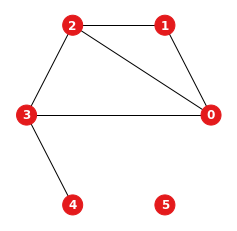

In [19]:
# Given number of vertices (N) and number of colors (K)
N = 6
K = 3

# Given edges
E = {(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4)}
plot_graph(N, E)

## ハミルトニアンの構築

大きさ$N \times K$の0-1の2値行列$x$を用意します。$x[i, k]=1$はノード$i$が色$k$であることを表します。

In [6]:
x = Array.create('x', (N, K), 'BINARY')

ハミルトニアン$H_{A}$を定義します。各ノードが一色で彩色されるようにする制約を表します。

In [7]:
onecolor_const = 0.0
for i in range(N):
    onecolor_const += Constraint((sum(x[i, :])-1)**2, label="onecolor{}".format(i))

ハミルトニアン$H_{B}$を定義します。隣り合うノードが同じ色にならなようにするためのペナルティです。

In [20]:
# Define hamiltonian H_{A}: Constraint that no adjacent nodes are colored with the same color
adjacent_const = 0.0
for (i, j) in E:
    for k in range(K):
        adjacent_const += Constraint(x[i, k] * x[j, k], label="adjacent({},{})".format(i, j))

全体のハミルトニアン$H$を構築します。この時、パラメータalphaを使って、ハミルトニアンのバランスを取るようにします。

In [21]:
alpha = Placeholder("alpha")
H = alpha * onecolor_const + adjacent_const

## QUBOの生成

PyQUBOのハミルトニアンをコンパイルして、モデルオブジェクト(model)を構築します。次に、パラメータalphaの数値を1.0と指定してdimodのBQMオブジェクト(bqm)を作成します。

In [10]:
# Compile model
model = H.compile()

# Create QUBO with alpha = 1.0
feed_dict = {'alpha': 1.0}
bqm = model.to_bqm(feed_dict=feed_dict)

## SAによる解の探索

nealパッケージのSAを使って上で作成したbqmのエネルギーを最小にするような解を得ます。この解を元の問題におけるノードの色の情報として取得します。

In [29]:
# nealのSAを使って解の探索を行う
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

# 解のデコード
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)

# 破れている制約が何個あるか確認する。制約が破れていたら、パラメータalphaの調整をやり直す必要がある
print("number of broken constarint = {}".format(len(best_sample.constraints(only_broken=True))))

# ノードにおける色を取得する
colors = [0 for i in range(N)]
for i in range(N):
    for k in range(K):
        if best_sample.array('x', (i, k)) == 1:
            colors[i] = k
            break

number of broken constarint = 0


## 得られた解の描画

最後に、取得した色の情報を付与してグラフを描画します。隣り合う色が同じ色になっていないことが確認できました。

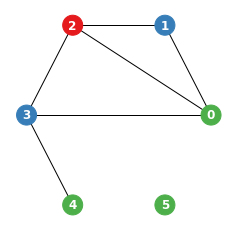

In [28]:
plot_graph(N, E, colors)